# TensorFlow WTA

## Intro
* **Date**: 12/7/2020
* **What**: Basically, I'm seeing if the weight matrices learned in the first layer of a TensorFlow mnist classifier have a good WTA classification.
* **Why**: If the WTA classification accuracy is about the same as the model accuracy, then I'll have stronger evidence to suggest that TensorFlow is basically prototype matching like DreamFlow, but with more convoluted prototypes.
* **Hopes**: If the first layer of a DNN is just pattern matching, then that'll be a self-esteem boost.
* **Limitations**: If wta has nothing to do with anything, then that's just irritating.

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
def draw_weights(w, Kx, Ky, fig):
    tapestry = np.zeros((28 * Kx, 28 * Ky))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * 28: (y + 1) * 28, x * 28: (x + 1) * 28] = w[w_i].reshape(28, 28)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="bwr", vmax=max_val, vmin=-max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

In [4]:
def wta_classification(w):
    L = 28 * 28
    
    flat_x = np.reshape(train_x, [-1, L])
    flat_test = np.reshape(test_x, [-1, L])
    
    v = flat_x
    train_lbls = train_y
    
    v = v / np.array([np.linalg.norm(v, axis=1)]).T
    w = w / np.array([np.linalg.norm(w, axis=1)]).T
    
    wins = np.argmax(w @ (flat_x).T, axis=0)
    
    n_wins = np.zeros((w.shape[0], 10))
    
    for (n_i, lbl) in zip(wins, train_lbls):
        n_wins[n_i][lbl] += 1
        
    n_cls = np.argmax(n_wins, axis=1)
    print("Neuron classes:", n_cls)
    
    num_test = test_y.shape[0]
    test_v = flat_test / np.array([np.linalg.norm(flat_test, axis=1)]).T
    
    num_correct = 0
    
    incorrect = np.zeros(10)
    
    for i in range(num_test):
        w_mul_v = w @ test_v[i].T
        
        n_max = np.argmax(w_mul_v)
        
        pre = n_cls[n_max]
        if pre == test_y[i]:
            num_correct += 1
        else:
            incorrect[test_y[i]] += 1
            
    print("Accuracy:", str(num_correct * 100 / num_test) + '%')
    print("Misclassifieds: ", incorrect)

In [5]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x, test_x = train_x / 255.0, test_x / 255.0

In [10]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(100, use_bias=False),
    Dense(10, use_bias=False)
])

model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [11]:
model.fit(train_x, train_y, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4736 - accuracy: 0.8635
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3062 - accuracy: 0.9130
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2874 - accuracy: 0.9178
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2808 - accuracy: 0.9210
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2747 - accuracy: 0.9234
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2693 - accuracy: 0.9234
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2719 - accuracy: 0.9252
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2711 - accuracy: 0.9249
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2632 - accuracy: 0.9272
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.272

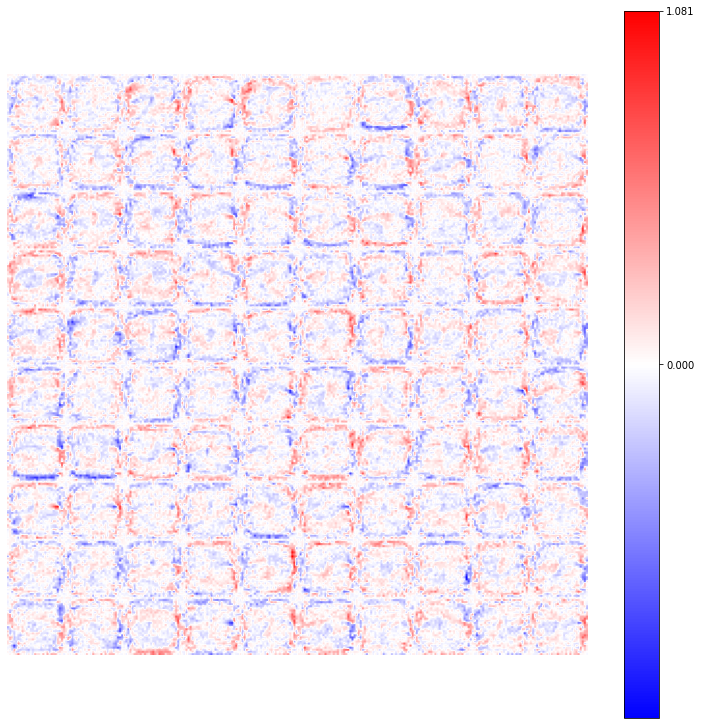

In [12]:
fig = plt.figure(figsize=(13, 13))

draw_weights(model.layers[1].trainable_variables[0].numpy().T, 10, 10, fig)

## Analysis Dialog

Whelp, those don't even barely look like prototypes.  Here's the wta:

In [38]:
wta_classification(model.layers[1].trainable_variables[0].numpy().T)

Neuron classes: [0 5 1 8 0 5 5 0 0 6 7 9 5 1 2 5 2 2 3 0 4 8 7 3 7 0 5 7 0 4 5 4 4 5 1 0 7
 1 2 6 7 0 3 2 8 0 5 0 7 0 8 6 1 0 1 7 5 5 5 0 1 2 6 3 1 6 2 6 7 9 0 5 4 7
 1 0 9 8 4 4 6 3 5 2 1 5 2 4 0 9 4 5 3 9 3 2 2 6 6 1]
Accuracy: 54.08%
Misclassifieds:  [105. 109. 511. 712. 217. 805. 239. 468. 607. 819.]


Well, that's that, I suppose.  I'm going to take a quick peak at the final layer.

<BarContainer object of 100 artists>

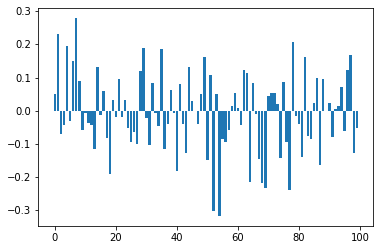

In [47]:
plt.bar(np.arange(100), model.layers[2].trainable_variables[0].numpy().T[0])

<BarContainer object of 100 artists>

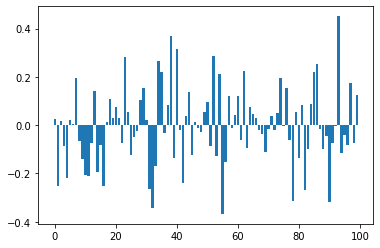

In [48]:
plt.bar(np.arange(100), model.layers[2].trainable_variables[0].numpy().T[1])

<BarContainer object of 100 artists>

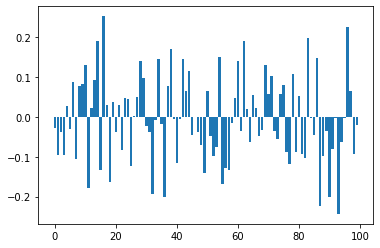

In [49]:
plt.bar(np.arange(100), model.layers[2].trainable_variables[0].numpy().T[2])

<BarContainer object of 100 artists>

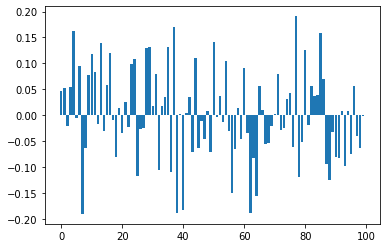

In [50]:
plt.bar(np.arange(100), model.layers[2].trainable_variables[0].numpy().T[8])

Well, this tells me just about nothing.  I'm going to train this bad boi for a couple more epochs, and then take a peak at the weight prototypes again.

In [13]:
model.fit(train_x, train_y, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2686 - accuracy: 0.9260
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2657 - accuracy: 0.9259
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2654 - accuracy: 0.9259
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2642 - accuracy: 0.9273
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2629 - accuracy: 0.9273
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2622 - accuracy: 0.9268
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2613 - accuracy: 0.9282
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2595 - accuracy: 0.9284
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2582 - accuracy: 0.9285
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.258

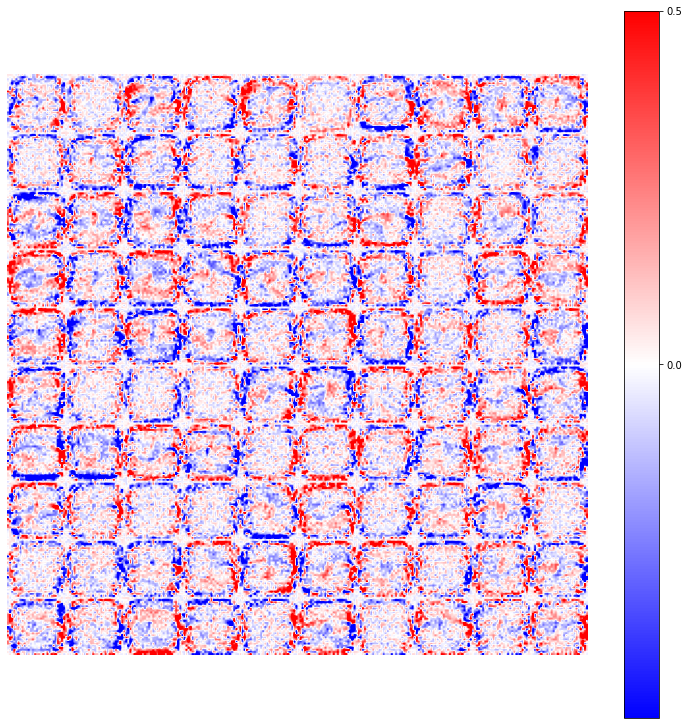

In [16]:
fig = plt.figure(figsize=(13, 13))

draw_weights(model.layers[1].trainable_variables[0].numpy().T, 10, 10, fig)

I just changed max_val in `draw_weights`, in case you want to change it back.  I just wanted to see if I was missing something because everything was so light.  I wasn't.  

## Conclusions

Well, apparently DNNs trained with backprop aren't doing anything remotely similar to wta learning.  I mean, that's not super surprising.  It's just doing function approximation.  Hmm.  Yeah it certainly doesn't look remotely similar to consciousness.  Kinda a lame experiment, ngl.

## Next steps

Digit recognition is kinda driving me nuts.  At the same time, it's a basic symbol set, so it seems like a good place to start in actually building up higher-order functionality.  

I don't really know what's next.  After DreamFlow failed, I didn't have a good idea of what to try next, so I'm just trying to figure out my next steps.  So yeah, no next steps at the moment.

I'm briefly opening this experiment back up, because I didn't use an activation function in training the network.  So yeah, everything was disgustingly linear.  I'll use relu, and see what we get.

In [6]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(100, use_bias=False, activation='relu'),
    Dense(10, use_bias=False)
])

model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [7]:
model.fit(train_x, train_y, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4520 - accuracy: 0.8712
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1390 - accuracy: 0.9599
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0869 - accuracy: 0.9736
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0611 - accuracy: 0.9823
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0474 - accuracy: 0.9865
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0390 - accuracy: 0.9888
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0336 - accuracy: 0.9901
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0268 - accuracy: 0.9917
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0211 - accuracy: 0.9937
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.017

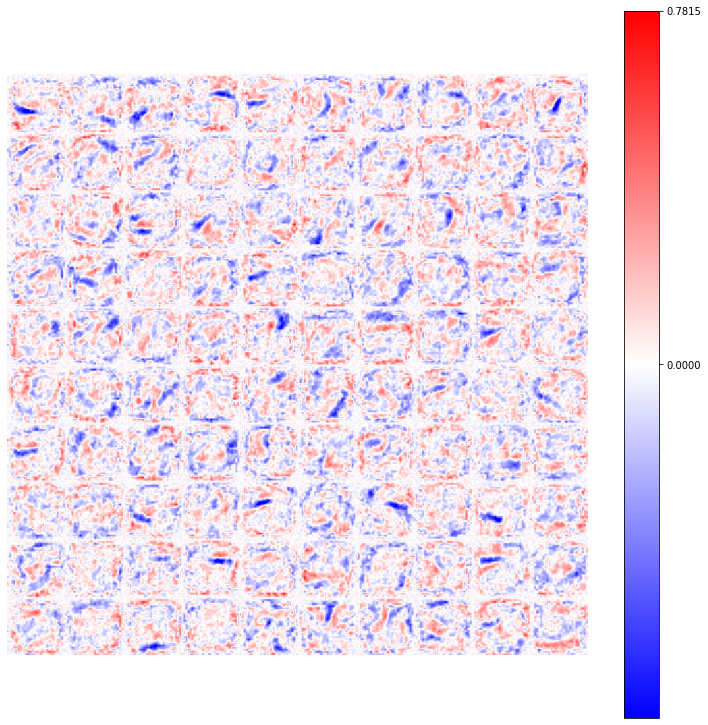

In [10]:
fig = plt.figure(figsize=(13, 13))

draw_weights(model.layers[1].trainable_variables[0].numpy().T, 10, 10, fig)

In [11]:
wta_classification(model.layers[1].trainable_variables[0].numpy().T)

Neuron classes: [3 7 7 5 2 7 4 6 3 0 9 2 8 0 0 9 0 2 5 2 0 5 2 8 2 7 1 0 2 2 9 3 6 7 2 9 4
 9 7 0 4 1 6 1 1 7 7 4 2 8 6 3 1 2 5 1 5 3 0 5 7 6 5 6 4 6 3 9 4 3 8 6 9 0
 3 9 5 4 7 7 5 0 6 5 7 4 9 2 2 4 7 9 6 8 7 4 6 4 2 3]
Accuracy: 49.41%
Misclassifieds:  [588. 101. 558. 273. 642. 692. 279. 419. 748. 759.]


Yeah, ok, so same result.  The end.